In [ ]:
%tensorflow_version 2.3.1
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.3.1`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
Tensorflow version 2.4.0
Running on TPU  ['10.76.142.122:8470']


In [ ]:
import numpy
from tensorflow import keras
from tensorflow.keras import layers, backend
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Activation, MaxPool2D, Dropout, BatchNormalization
from numpy import asarray
import pathlib
from pathlib import Path
import sys
from sys import path
import glob
import os
from os import path

In [ ]:
path = "/content/drive/My Drive/BMI_Test/"

In [ ]:
images = list(path.glob("*/*.jpg"))

In [ ]:
from google.cloud import storage

In [ ]:
gcs_pattern = 'gs://tinderautomationdata/imageclasstest/Rankset/*/*.jpg'

In [ ]:
validation_split = 0.19
filenames = tf.io.gfile.glob(gcs_pattern)

In [ ]:
split = len(filenames) - int(len(filenames) * validation_split)
print(split)
print(int(len(filenames) * validation_split))

4442
1041


In [ ]:
train_fns = filenames[:split]
validation_fns = filenames[split:]

In [ ]:
def parse_tfrecord(example):
  features = {
    "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
    "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means scalar
    "one_hot_class": tf.io.VarLenFeature(tf.float32),
  }
  example = tf.io.parse_single_example(example, features)
  decoded = tf.image.decode_jpeg(example['image'], channels=3)
  normalized = tf.cast(decoded, tf.float32) / 255.0 # convert each 0-255 value to floats in [0, 1] range
  image_tensor = tf.reshape(normalized, [*IMAGE_SIZE, 3])
  one_hot_class = tf.reshape(tf.sparse.to_dense(example['one_hot_class']), [17])
  return image_tensor, one_hot_class
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    label = parts[-2]
    return label
def decode_img(file, img_height, img_width):
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.cast(img, tf.float32)
  return tf.image.resize(img, [img_height, img_width])

# Decodes jpeg images as tensors

def process_path(file_path):
  parts = tf.strings.split(filename, os.sep)
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels = 3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, [128, 128])
  return image

# processes the entirity of the filename

def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = get_label(filename)
  image = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image, [128, 128])
  image = tf.image.convert_image_dtype(image, tf.float32)/255
  return image, label

#configures dataset

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(32)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def get_training_dataset():
  dataset = load_dataset(train_fns)

  # Create some additional training images by randomly flipping and
  # increasing/decreasing the saturation of images in the training set.
  def data_augment(image, one_hot_class):
    modified = tf.image.random_flip_left_right(image)
    modified = tf.image.random_saturation(modified, 0, 2)
    return modified, one_hot_class
  augmented = dataset.map(data_augment, num_parallel_calls=AUTO)

  # Prefetch the next batch while training (autotune prefetch buffer size).
  return augmented.repeat().shuffle(2048).batch(batch_size).prefetch(AUTO)

def load_dataset(filenames):
  # Read from TFRecords. For optimal performance, we interleave reads from multiple files.
  records = tf.data.Dataset.list_files(filenames)
  return records.map(parse_image)
  # Prefetch the next batch while training (autotune prefetch buffer size).

def get_dataset_iterator(dataset, n_examples):
  return dataset.unbatch().batch(n_examples).as_numpy_iterator()

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
batch_size = 16 * tpu_strategy.num_replicas_in_sync
IMAGE_SIZE = [128,128]

  # Create some additional training images by randomly flipping and
  # increasing/decreasing the saturation of images in the training set.


training_dataset = load_dataset(train_fns).batch(batch_size).prefetch(AUTO)
validation_dataset = load_dataset(validation_fns).batch(batch_size).prefetch(AUTO)

# Re-run this cell to show a new batch of images



In [ ]:
def create_model():
  pretrained_model = tf.keras.applications.Xception(input_shape=[*IMAGE_SIZE, 3], include_top=False)
  pretrained_model.trainable = True
  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(17, activation='softmax')
  ])
  model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
  )
  return model

with tpu_strategy.scope(): # creating the model in the TPUStrategy scope means we will train the model on the TPU
  model = create_model()
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 17)                34833     
Total params: 20,896,313
Trainable params: 20,841,785
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
print(split)

4442


In [ ]:
number = 4442//batch_size
print(number)

34


In [ ]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005 * tpu_strategy.num_replicas_in_sync
rampup_epochs = 17
sustain_epochs = 17
exp_decay = .8

In [ ]:
def lrfn(epoch):
  if epoch < rampup_epochs:
    return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
  elif epoch < rampup_epochs + sustain_epochs:
    return max_lr
  else:
    return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

In [ ]:
import re
import numpy as np
from matplotlib import pyplot as plt

Learning rate per epoch:


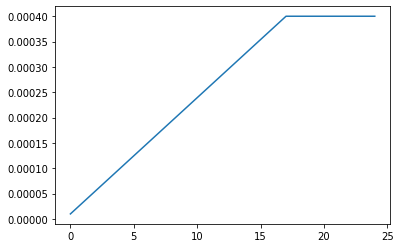

In [ ]:
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=True)
EPOCHS = 25
rang = np.arange(EPOCHS)
y = [lrfn(x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

In [ ]:
history = model.fit(training_dataset, validation_data=validation_dataset,steps_per_epoch=number, epochs=EPOCHS,
                    callbacks=[lr_callback])

final_accuracy = history.history["val_accuracy"][-5:]
print("FINAL ACCURACY MEAN-5: ", np.mean(final_accuracy))

Epoch 1/25

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.


ValueError: ignored